In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yfin

In [2]:
# import data
def get_data(stocks, start, end):
    yfin.pdr_override()
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Adj Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    
    return meanReturns, covMatrix

In [3]:
stockList = ['BNS.TO', 'GOOGL', 'XOM', 'NIO', 'KO', 'PEP','ARCC','IBM','AGNC','LCID']
stocks = [stock for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=300)

meanReturns, covMatrix = get_data(stocks, startDate, endDate)

weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

# print(meanReturns)
# print(covMatrix)
# print(weights)

[*********************100%%**********************]  10 of 10 completed


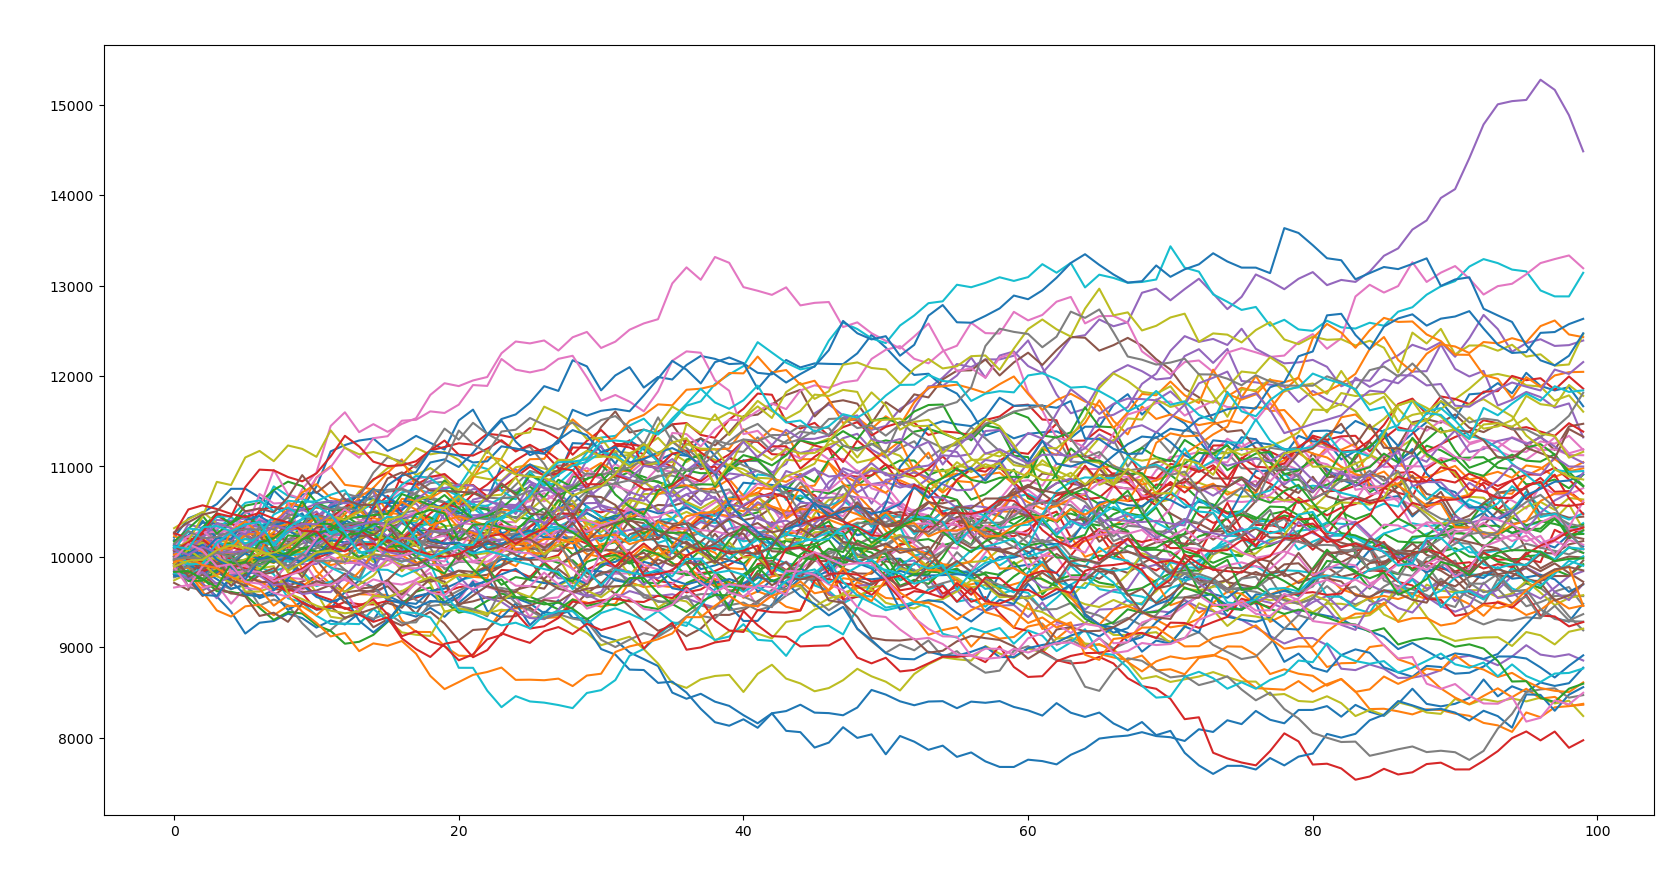

In [4]:
# Monte Carlo simulation
mc_sims = 100 # number of simulations
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights)))#uncorrelated RV's
    L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to Lower Triangular Matrix
    dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

font = {'family': 'serif',
        'color':  'white',
        'weight': 'normal',
        'size': 25,
        }
plt.figure(figsize=(20, 10))
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)',  fontdict=font)
plt.xlabel('Days',  fontdict=font)
plt.title('Monte carlo simulation of a stock portfolio',  fontdict=font)
plt.show()

In [5]:
def mcVaR(returns, alpha):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [6]:
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, 5)
CVaR = initialPortfolio - mcCVaR(portResults, 5)

print('VaR ${:,.2f}'.format(VaR,2))
print('CVaR ${:,.2f}'.format(CVaR,2))

VaR $1,504.23
CVaR $1,715.27
